## Time-resolved single-gene analyses

### 1 Prepare data

Write part of the directory listing to a variable:

In [1]:
import platform

files = !ls ../../results/volume*

Set up a dictionary that contains the simulation results.

In [2]:
import re

filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        filepaths[int(match.group(1).zfill(4))] = file

In [3]:
print filepaths

{0: '../../results/volume-adjusted polyphasic cell cycle v2 from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_1525_200000_ribosomes_2100s.p', 2400: '../../results/volume-adjusted polyphasic cell cycle v2 from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2237_286153_ribosomes_2100s.p', 3300: '../../results/volume-adjusted polyphasic cell cycle v2 from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190308_0108_318461_ribosomes_2100s.p', 1800: '../../results/volume-adjusted polyphasic cell cycle v2 from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2055_264615_ribosomes_2100s.p', 300: '../../results/volume-adjusted polyphasic cell cycle v2 from 300 

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [4]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path, 'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [5]:
for time in filepaths:
    print time,
    #replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


In [6]:
import cPickle as pkl

results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-2}

0 ../../results/volume-adjusted polyphasic cell cycle v2 from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_1525_200000_ribosomes_2100s.p
2400 ../../results/volume-adjusted polyphasic cell cycle v2 from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2237_286153_ribosomes_2100s.p
3300 ../../results/volume-adjusted polyphasic cell cycle v2 from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190308_0108_318461_ribosomes_2100s.p
1800 ../../results/volume-adjusted polyphasic cell cycle v2 from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2055_264615_ribosomes_2100s.p
300 ../../results/volume-adjusted polyphasic cell cycle v2 from 300 to 600, Teufel tran

### 2 Test burn-in period

Plot timecourses:

In [7]:
import numpy as np
import random

time = 300  # any cell cycle time shuld be tested in theory
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

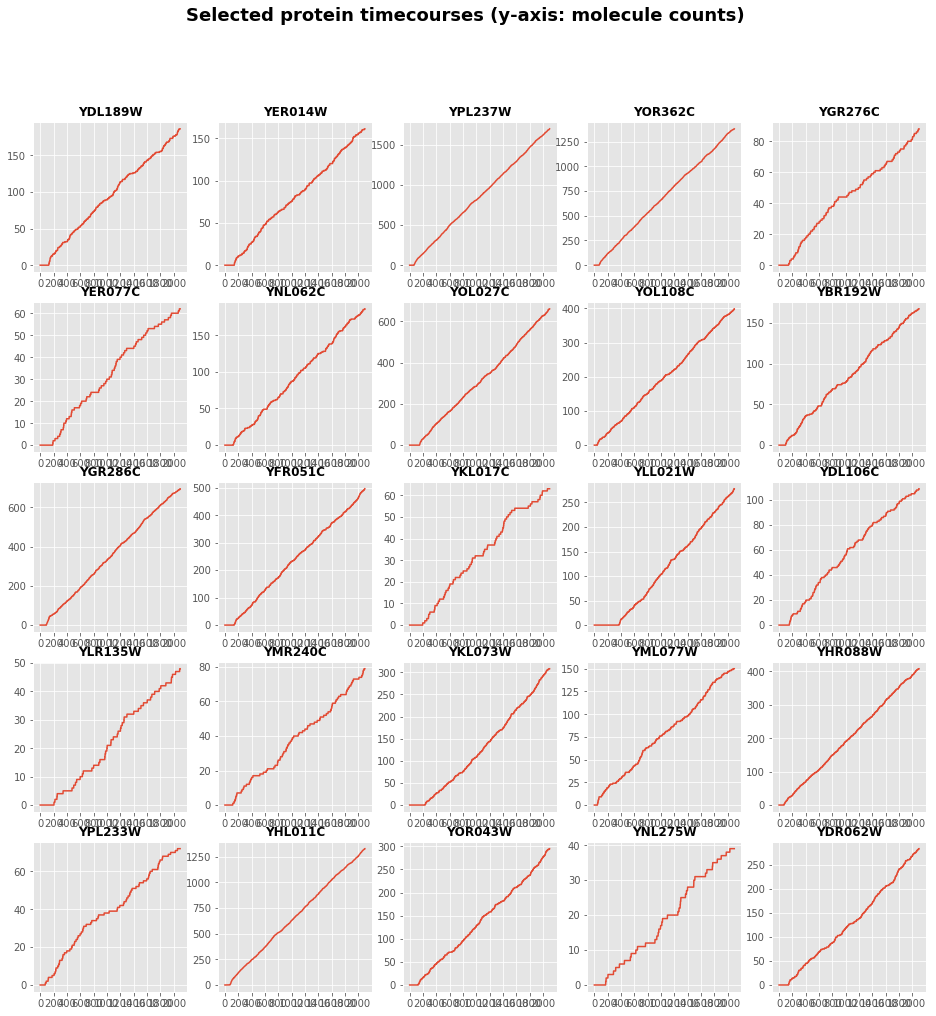

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax = plt.subplots(size, size, figsize=(16, 16))

plt.suptitle('Selected protein timecourses (y-axis: molecule counts)', fontsize=18, fontweight='bold')

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

### 3 Single-gene analysis

In [9]:
genes_shortlist = {'HHF1': 'YBR009C', 'HHF2': 'YNL030W', 'HHT1': 'YBR010W', 'HHT2': 'YNL031C', 'HTB1': 'YDR224C', 
                   'HTB2': 'YBL002W', # 'PMA1': 'YGL008C', 
                   # 'RNR1': 'YER070W', 'RNR2': 'YJL026W', 'RNR3': 'YIL066C', 'RNR4': 'YGR180C', 
                   # genes suggested by Katja, some histones
                   'SIC1': 'YLR079W', 'CLN2': 'YPL256C', 'CLB2': 'YPR119W', 'CLB5': 'YPR120C', 
                   'PCL1': 'YNL289W', 'PCL9': 'YDL179W', 'SWE1': 'YJL187C'} # FISH genes

In [10]:
translation_rate_shortlist = {}

for (genecommon, gene) in genes_shortlist.items():
    translation_rate_shortlist[genecommon] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-601])/600.
        else:
            rate = 0.
        translation_rate_shortlist[genecommon].append(rate)

In [11]:
import pandas as pd

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

Text(0,0.5,u'proteins/s')

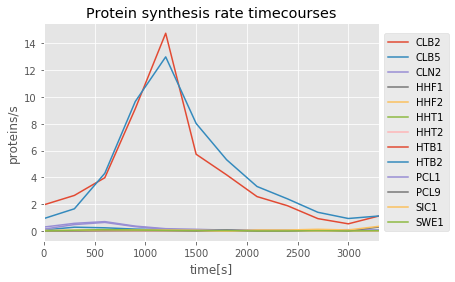

In [12]:
pl = translation_ratedf.plot(title="Protein synthesis rate timecourses")

pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/s")

For these genes, find mRNA time courses:

In [34]:
import collections

transcriptomes_dict = collections.OrderedDict(sorted(
        pkl.load((open('../../parameters/transcriptome_time_dependent_v2.p'))).items()))

In [35]:
transcriptomes_df = pd.DataFrame(transcriptomes_dict).transpose()

In [36]:
transcriptomes_df.set_index(np.arange(0, 3601, 300), inplace=True)

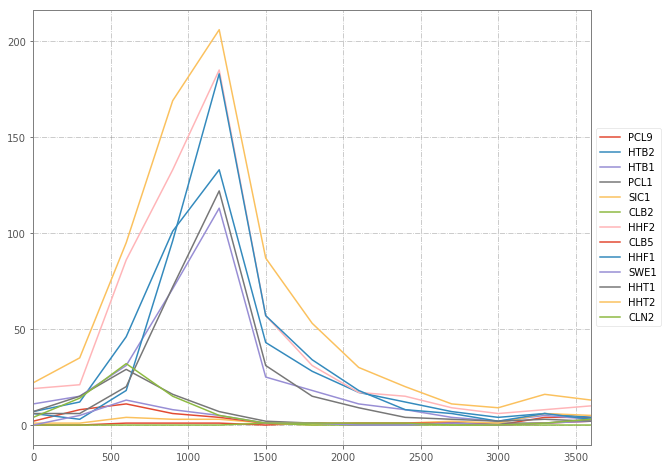

In [37]:
transcriptomes_short_df = transcriptomes_df[genes_shortlist.values()]
transcriptomes_short_df.columns = genes_shortlist.keys()
transcriptomes_short_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [38]:
transcriptomes_short_df = transcriptomes_short_df[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                   #'HHF1', 'HHF2', 'HHT1', 'HHT2', # no initiation rates
                                                   'HTB1', 'HTB2']]
transcriptomes_short_df

,CLB2,CLB5,CLN2,PCL1,PCL9,SIC1,SWE1,HTB1,HTB2
0,0,2,4,7,0,1,0,11,7
300,0,8,14,15,0,1,5,15,12
600,0,11,32,29,1,4,13,31,46
900,0,6,15,16,1,3,8,71,101
1200,0,4,5,7,1,3,5,113,133
1500,1,1,1,2,0,1,1,25,43
1800,0,1,1,1,1,0,1,18,28
2100,0,1,1,0,0,1,0,11,17
2400,0,1,1,0,0,1,0,8,12
2700,0,1,0,1,1,2,1,4,7


In [39]:
translation_ratedf

,CLB2,CLB5,CLN2,HHF1,HHF2,HHT1,HHT2,HTB1,HTB2,PCL1,PCL9,SIC1,SWE1
0,0.000000,0.068333,0.135000,0.0,0.0,0.0,0.0,1.948333,0.923333,0.288333,0.000000,0.041667,0.000000
300,0.000000,0.278333,0.473333,0.0,0.0,0.0,0.0,2.650000,1.651667,0.566667,0.000000,0.041667,0.053333
600,0.000000,0.233333,0.635000,0.0,0.0,0.0,0.0,3.971667,4.301667,0.695000,0.020000,0.086667,0.098333
900,0.000000,0.136667,0.318333,0.0,0.0,0.0,0.0,9.120000,9.658333,0.358333,0.028333,0.073333,0.070000
1200,0.000000,0.090000,0.116667,0.0,0.0,0.0,0.0,14.756667,12.993333,0.166667,0.026667,0.065000,0.036667
1500,0.058333,0.043333,0.043333,0.0,0.0,0.0,0.0,5.723333,8.021667,0.121667,0.000000,0.050000,0.023333
1800,0.000000,0.048333,0.051667,0.0,0.0,0.0,0.0,4.186667,5.316667,0.060000,0.065000,0.000000,0.026667
2100,0.000000,0.048333,0.061667,0.0,0.0,0.0,0.0,2.563333,3.316667,0.000000,0.000000,0.071667,0.000000
2400,0.000000,0.050000,0.040000,0.0,0.0,0.0,0.0,1.881667,2.395000,0.000000,0.000000,0.070000,0.000000
2700,0.000000,0.055000,0.000000,0.0,0.0,0.0,0.0,0.918333,1.390000,0.066667,0.078333,0.121667,0.015000


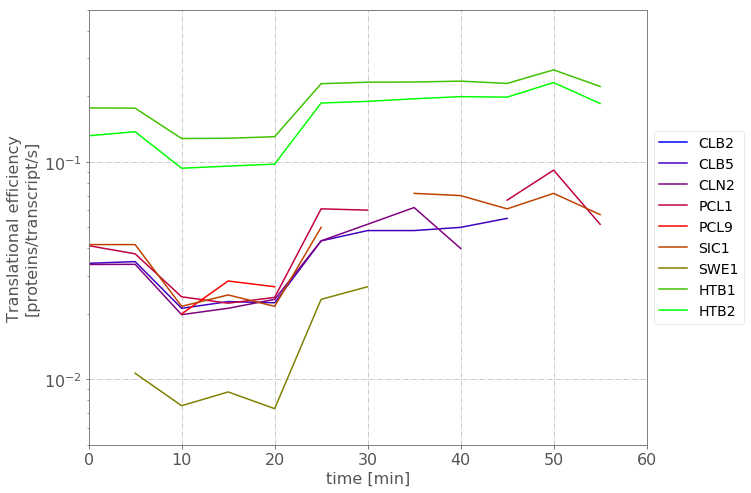

In [40]:
plt.rcParams['figure.figsize'] = (10, 8)

ratio = translation_ratedf.div(transcriptomes_short_df)[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                         #'HHF1', 'HHF2', 'HHT1', 'HHT2', 
                                                         'HTB1', 'HTB2']]
ratio.set_index(np.arange(0, 61, 5), inplace=True)
ax = ratio.plot(logy=True, ylim=[5e-3, 5e-1], colormap='brg')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
ax.set_xlabel("time [min]", fontsize=16)
ax.set_ylabel("Translational efficiency\n[proteins/transcript/s]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

In [41]:
init_rates = pkl.load(open("../../parameters/init_rates_plotkin.p", "rb"))

In [42]:
for gene in ['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 'HHF1', 'HHF2', 'HHT1', 'HHT2', 'HTB1', 
             'HTB2']:
    if genes_shortlist[gene] in init_rates:
        print gene, genes_shortlist[gene], init_rates[genes_shortlist[gene]]

CLB2 YPR119W 1.07863479792e-06
CLB5 YPR120C 1.08393456684e-06
CLN2 YPL256C 1.07536488822e-06
PCL1 YNL289W 1.27382287498e-06
PCL9 YDL179W 1.42121527966e-06
SIC1 YLR079W 1.15695247462e-06
SWE1 YJL187C 3.75113962529e-07
HTB1 YDR224C 8.58045121193e-06
HTB2 YBL002W 5.73892764002e-06


### 4 Time-resolved translational efficiencies csv

In [43]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
all_genes = orf_genomic_dict.keys()

In [44]:
translation_rate_full = {}

for time in np.arange(0, 3600, 300):
    for gene in all_genes:
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-601])/600.
            translation_rate_full.setdefault(gene, []).append(rate)
        else:
            translation_rate_full.setdefault(gene, []).append(0.0)

In [45]:
translation_rate_full_df = pd.DataFrame(translation_rate_full, index=np.arange(0, 3600, 300))

In [46]:
translation_rate_full_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.028333,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.086667,0.013333,0.0,0.0,0.0,0.0,0.0,0.0
600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.046667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.078333,0.015000,0.0,0.0,0.0,0.0,0.0,0.0
1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.050000,0.020000,0.0,0.0,0.0,0.0,0.0,0.0
1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.071667,0.020000,0.0,0.0,0.0,0.0,0.0,0.0
1800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.071667,0.040000,0.0,0.0,0.0,0.0,0.0,0.0
2100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.061667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.060000,0.023333,0.0,0.0,0.0,0.0,0.0,0.0
2700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.068333,0.030000,0.0,0.0,0.0,0.0,0.0,0.0


Output df (e.g. for Jens):

In [47]:
pkl.dump(translation_rate_full_df, open("../../parameters/translation_rate_full_df.p", "wb"))

In [48]:
te = translation_rate_full_df.div(transcriptomes_df)

In [49]:
te = te.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [50]:
te

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR194C,YPR196W,YPR198W,YPR199C,YPR200C
0,0.026667,0.013333,0.142579,0.0,0.054167,0.074167,0.027778,0.033333,0.025000,0.112587,...,0.072381,0.051667,0.043889,0.030556,0.058333,NaN,NaN,NaN,0.028333,NaN
300,0.023333,NaN,0.143810,0.0,0.061111,0.083333,0.028333,NaN,0.031667,0.114672,...,0.072727,0.052778,0.035000,0.037500,0.063333,NaN,NaN,0.043333,0.013333,0.0
600,0.010833,0.011667,0.098534,0.0,0.033788,0.049167,0.017222,NaN,0.025000,0.075221,...,0.045145,0.033889,0.018889,0.018750,0.046111,NaN,NaN,0.023333,NaN,0.0
900,0.015000,0.008333,0.098801,0.0,0.038889,0.056000,0.016111,0.018333,0.017778,0.078857,...,0.045833,0.035417,0.022917,0.026250,0.045833,NaN,0.0,0.026111,0.015000,NaN
1200,0.018333,0.006667,0.104697,0.0,0.038333,0.055000,0.022500,0.013333,0.022500,0.080982,...,0.048846,0.033000,0.024167,0.027292,0.038333,0.0,NaN,0.025000,0.010000,0.0
1500,0.036667,0.015000,0.198377,0.0,0.094444,0.117500,0.038333,NaN,NaN,0.165161,...,0.098542,0.085833,0.048333,0.051667,0.110000,NaN,NaN,0.071667,0.020000,NaN
1800,0.040000,0.013333,0.197895,0.0,0.097778,0.118333,0.035833,NaN,0.041667,0.164095,...,0.102857,0.091667,0.050000,0.055000,0.088333,NaN,NaN,0.071667,0.040000,NaN
2100,NaN,0.026667,0.201111,0.0,0.088333,0.120000,0.041667,NaN,0.061667,0.167304,...,0.103958,0.083333,0.056667,0.051667,0.090000,NaN,NaN,0.061667,NaN,NaN
2400,0.036667,0.005000,0.202593,0.0,0.100833,0.130000,0.040556,NaN,NaN,0.165707,...,0.112121,0.093333,0.065000,0.053333,0.096667,NaN,NaN,0.060000,0.023333,NaN
2700,0.033333,0.021667,0.202376,0.0,0.098333,0.125000,0.048333,NaN,0.065000,0.170325,...,0.109848,0.082500,0.051667,0.059167,0.102500,NaN,NaN,0.068333,0.030000,NaN


In [51]:
import csv

with open('../../results/init_rates.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['gene', 'rate'])
    for key, value in init_rates.items():
        writer.writerow([key, value*1000000])

In [52]:
te.transpose().to_csv('../../results/te_time-resolved.csv')

In [53]:
pkl.dump(te.transpose(), open("../../parameters/te_time-resolved.p", "wb"))

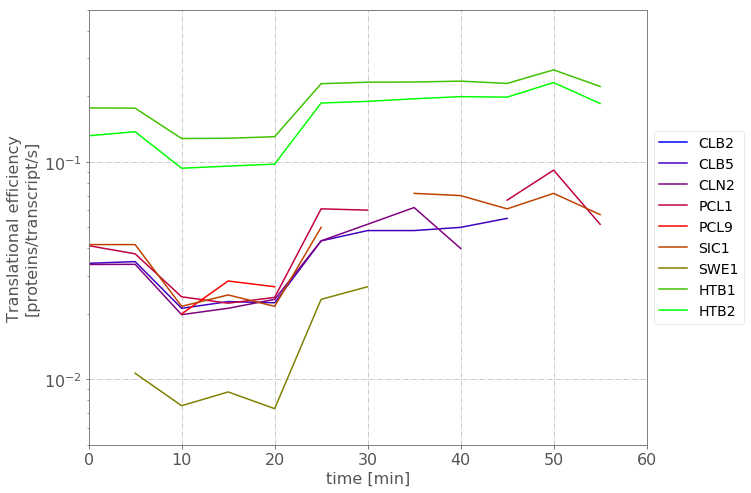

In [54]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = '0.5'
plt.rcParams['grid.linestyle'] = '-.'
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.sans-serif'] = 'Times New Roman'

plt.rcParams['figure.figsize'] = (10, 8)

ratio = translation_ratedf.div(transcriptomes_short_df)[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                         #'HHF1', 'HHF2', 'HHT1', 'HHT2', 
                                                         'HTB1', 'HTB2']]
ratio.set_index(np.arange(0, 61, 5), inplace=True)
ax = ratio.plot(logy=True, ylim=[5e-3, 5e-1], colormap='brg')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
ax.set_xlabel("time [min]", fontsize=16)
ax.set_ylabel("Translational efficiency\n[proteins/transcript/s]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('time_resolved_single_gene_results.pdf', bbox_inches='tight')